# Setting

In [1]:
# !pip install datasets
# !pip install transformers

In [12]:
import os
import glob
import random
import time
import torch
import torch.nn as nn
import torch.optim as optim
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image
from collections import Counter
from sklearn.preprocessing import LabelEncoder

from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import random_split

import torchvision.transforms as T

from perceiver import crop, patchify, get_patch_coords, ImageDataset, PerceiverBlock, Perceiver

In [3]:
def seed_everything(seed):
    torch.manual_seed(seed) #torch를 거치는 모든 난수들의 생성순서를 고정한다
    torch.cuda.manual_seed(seed) #cuda를 사용하는 메소드들의 난수시드는 따로 고정해줘야한다 
    torch.cuda.manual_seed_all(seed)  # if use multi-GPU
    torch.backends.cudnn.deterministic = True #딥러닝에 특화된 CuDNN의 난수시드도 고정 
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed) #numpy를 사용할 경우 고정
    random.seed(seed) #파이썬 자체 모듈 random 모듈의 시드 고정
seed_everything(42)

# Load Data

In [4]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [5]:
def train_model(model, train_loader, valid_loader, criterion, optimizer, epochs, device, scheduler=None):
    best_model = None 
    best_val_score = 0
    model.train()
    train_losses = []
    val_accuracies = []
    start = time.perf_counter()
    for epoch in range(epochs):
        total_loss = 0.0
        for images, labels in train_loader:
            # GPU로 옮기기
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        train_losses.append(avg_loss)

        accuracy = evaluate_model(model, valid_loader, device=device, log_results=False)
        val_accuracies.append(accuracy)

        # Scheduler step 추가
        if scheduler:
            scheduler.step()

        print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}, Val Accuracy: {accuracy:.2f}%")
        if accuracy > best_val_score:
            best_val_score = accuracy
            best_model_state = model.state_dict()  # 모델 상태 저장
            print(f"New best model found at epoch {epoch+1} with accuracy: {best_val_score:.2f}%")

    end = time.perf_counter()
    hour = (end-start) // 3600
    min = ((end-start) % 3600) // 60
    sec = int((end-start) % 60)
    print(f"Total Train time: {hour}h {min}m {sec}s")

    return train_losses, val_accuracies, best_model_state

def evaluate_model(model, data_loader, device, log_results=True):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        start = time.perf_counter()
        for images, labels in data_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        end = time.perf_counter()
        hour = (end-start) // 3600
        min = ((end-start) % 3600) // 60
        sec = (end-start) % 60
        print(f"Elapsed time on CPU: {hour}h {min}m {sec}s")

    accuracy = 100.0 * correct / total
    if log_results:
        print(f"Test Accuracy: {accuracy:.2f}%")
    return accuracy


In [6]:
def plot_learning_curve(train_losses, val_accuracies):
    fig, ax1 = plt.subplots()

    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Train Loss', color='tab:blue')
    ax1.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss', color='tab:blue')
    ax1.tick_params(axis='y', labelcolor='tab:blue')

    ax2 = ax1.twinx()
    ax2.set_ylabel('Validation Accuracy (%)', color='tab:orange')
    ax2.plot(range(1, len(val_accuracies) + 1), val_accuracies, label='Validation Accuracy', color='tab:orange')
    ax2.tick_params(axis='y', labelcolor='tab:orange')

    fig.tight_layout()
    plt.title('Learning Curve')
    plt.show()

In [7]:
data_dir = '/home/youlee/n24news/n24news/image'
crop_size = 0
patch_size = 16
batch_size = 32
epochs = 20
group_class = 3

# dataset = ImageDataset(root_dir=data_dir, transform=transform, crop_size=crop_size, patch_size=patch_size)
# label_encoder = dataset.label_encoder
# class_labels = label_encoder.classes_

# class_counts = {label:0 for label in class_labels}
# for _, label in dataset.data:
#     class_counts[label_encoder.inverse_transform([label])[0]] += 1

# target_classes = [label for label, count in class_counts.items() if count >= 2100]
# for label, count in class_counts.items():
#     if count>=2100:
#        print(f'{label}: {count}')


In [8]:
#random.shuffle(target_classes)
target_classes = [ # 임의로 순서지정
    "Opinion", "Art & Design", "Television",
    "Music", "Travel", "Real Estate",
    "Books", "Theater", "Health",
    "Sports", "Science", "Food",
    "Fashion & Style", "Movies", "Technology",
    "Dance", "Media", "Style"
]
target_classes

['Opinion',
 'Art & Design',
 'Television',
 'Music',
 'Travel',
 'Real Estate',
 'Books',
 'Theater',
 'Health',
 'Sports',
 'Science',
 'Food',
 'Fashion & Style',
 'Movies',
 'Technology',
 'Dance',
 'Media',
 'Style']

In [9]:
output_path = '/home/Minju/Perceiver/model'
loader_path = '/home/Minju/Perceiver/loader'

In [10]:
group_class

3

In [14]:
for i in range(0, len(target_classes), group_class):  
    print(f"실험 {i//group_class + 1} 시작")
    selected_classes = target_classes[i:i+group_class]
    print(f"Selected Feature: {selected_classes}")

    filtered_dataset = ImageDataset(root_dir=data_dir, 
                                    transform=transform, 
                                    crop_size=crop_size, 
                                    patch_size=patch_size,
                                    selected_classes=selected_classes)
    all_labels = [label_idx for (_, label_idx) in filtered_dataset.data]

    # 1) 유니크 라벨과 개수
    unique_label_ids = np.unique(all_labels)
    print("Unique numeric labels:", unique_label_ids)
    print("Number of unique numeric labels:", len(unique_label_ids))

    # 2) 라벨별 개수 (분포)
    label_counts = Counter(all_labels)
    print("Label distribution (index: count):", label_counts)
    
    train_ratio = 0.8
    train_size = int(len(filtered_dataset) * train_ratio)
    valid_size = len(filtered_dataset) - train_size

    train_dataset, valid_dataset = random_split(filtered_dataset, [train_size, valid_size])
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

    print(f"train: {train_size}, valid: {valid_size}")
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    NUM_CLASSES = len(filtered_dataset.label_encoder.classes_)
    model = Perceiver(input_dim=(patch_size**2) * 3 + 2,
                        latent_dim=128, 
                        latent_size=64, 
                        num_classes=NUM_CLASSES, 
                        num_blocks=4, 
                        self_attn_layers_per_block=10).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=1e-4)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)  # Learning rate decay 추가

    start = time.perf_counter()
    train_losses, val_accuracies, best_model_state = train_model(
        model, train_loader, valid_loader,
        criterion, optimizer, epochs,
        device=device,
        scheduler=scheduler  
    )
    
    # best_model_state를 모델에 로드
    model.load_state_dict(best_model_state)

    final_acc = evaluate_model(model, valid_loader, device=device, log_results=True)
    end = time.perf_counter()
    hour = (end-start) // 3600
    min = ((end-start) % 3600) // 60
    sec = int((end-start) % 60)
    print(f"Train time: {hour}h {min}m {sec}s")
    print(f"Final Validation Accuracy: {final_acc:.2f}%")
    print("----------------------------------------------------------")
    
    torch.save(model, f'{output_path}/image_model_{i//group_class+1}.pkl')

    val_loader_save_path = f"{loader_path}/image_val_loader_{i//group_class+1}.pkl"
    with open(val_loader_save_path, 'wb') as f:
        pickle.dump(valid_dataset, f)

실험 1 시작
Selected Feature: ['Opinion', 'Art & Design', 'Television']
Unique numeric labels: [0 1 2]
Number of unique numeric labels: 3
Label distribution (index: count): Counter({np.int64(1): 2437, np.int64(0): 2431, np.int64(2): 2419})
train: 5829, valid: 1458
Elapsed time on CPU: 0.0h 0.0m 9.742306522093713s
Epoch 1/20, Loss: 1.0774, Val Accuracy: 43.55%
New best model found at epoch 1 with accuracy: 43.55%
Elapsed time on CPU: 0.0h 0.0m 8.87109126499854s
Epoch 2/20, Loss: 1.0630, Val Accuracy: 42.66%
Elapsed time on CPU: 0.0h 0.0m 8.91362740797922s
Epoch 3/20, Loss: 1.0562, Val Accuracy: 42.46%
Elapsed time on CPU: 0.0h 0.0m 9.006429206114262s
Epoch 4/20, Loss: 1.0500, Val Accuracy: 38.75%
Elapsed time on CPU: 0.0h 0.0m 8.924473500112072s
Epoch 5/20, Loss: 1.0534, Val Accuracy: 42.87%
Elapsed time on CPU: 0.0h 0.0m 9.187732208054513s
Epoch 6/20, Loss: 1.0386, Val Accuracy: 44.38%
New best model found at epoch 6 with accuracy: 44.38%
Elapsed time on CPU: 0.0h 0.0m 9.04977039503865s
Ep

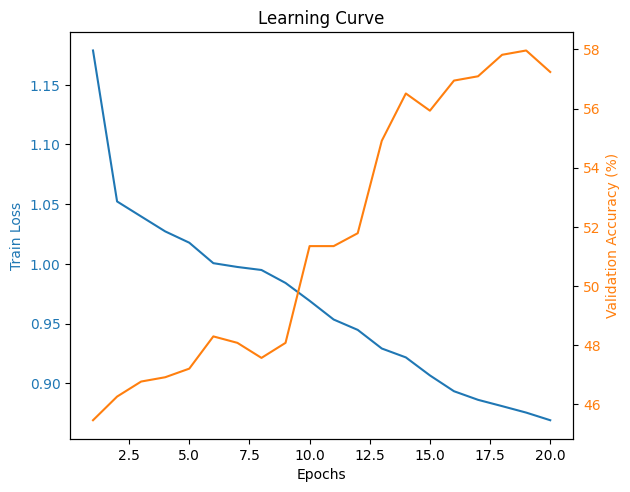

In [11]:
plot_learning_curve(train_losses, val_accuracies)

In [12]:
# mx = 0
# for i, acc in enumerate(val_accuracies):
#     if(val_accuracies[mx] < acc):
#         mx = i
# print(f'best trial: {mx+1} epoch, train loss: {train_losses[mx]}, val. acc: {val_accuracies[mx]}')